<a href="https://colab.research.google.com/github/Dhairya890/GIS-SEM1/blob/main/ps2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TITLE**

### *Exploring Crime, Education,Suicide rate and Unemployment: A GIS Project in India*


#**DESCRIPTION**

### *The primary objective of this project is to analyze and compare crime rates,education,Suicide rate and Unemployment status across different districts of India. By examining these three critical dimensions – population density, crime rates, and education levels*

#**DATASET SOURCES**

### Population Density Data:

#### https://www.kaggle.com/datasets/imdevskp/india-district-wise-shape-files

## Education Data:

#### https://livingatlas-dcdev.opendata.arcgis.com/datasets/esriindia1::india-education-2014-15/explore?showTable=true

## Crime Data:

#### https://data.gov.in/catalog/district-wise-crimes-under-various-sections-indian-penal-code-ipc-crimes

## SUICIDE DATA

#### https://data.gov.in/search?title=suicide

## UNEMPLOYMENT DATA

#### https://www.rbi.org.in/Scripts/PublicationsView.aspx?id=20001



## Importing libraries and setting up DataFrames

In [144]:
!pip install mapclassify
!pip install fuzzywuzzy
import fuzzywuzzy
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import mapclassify
import os, zipfile
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from google.colab import files
from google.colab import data_table
data_table.enable_dataframe_formatter()
import matplotlib.patches as mpatches
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import numpy as np

In [2]:
! wget -q -O IND.zip https://drive.google.com/uc?id=1opoGF1mPFkiZwwk-rloTDRAprs2gfCn_&export=download
! wget -q -O education.csv https://drive.google.com/uc?id=1ckGy6E6jDCLkhQgZnDcG8pV4KjqHpuFb&export=download
! wget -q -O crime.csv https://drive.google.com/uc?id=18RF0JXp9V1TnAd_EFy1Sy72wKrQQXLIt&export=download
! wget -q -O suicide.csv https://drive.google.com/uc?id=1EjHqHlxagt7S6yxVWQiN4oZcTP2j2Vk7&export=download
! wget -q -O unemp.csv https://drive.google.com/uc?id=1HMINnaozQDQn6Nkj5X-rXYaxy37yG3RV&export=download

zip_ref = zipfile.ZipFile('IND.zip', 'r'); zip_ref.extractall(); zip_ref.close()
Ind = gpd.read_file('INDIA-MAP.shp')

df_edu = pd.read_csv("education.csv")
df_crime = pd.read_csv("crime.csv")
df_suicide = pd.read_csv("suicide.csv")
df_suicide_main = pd.read_csv("suicide.csv")
df_unemp = pd.read_csv("unemp.csv")

In [3]:
# Removing NA values
l1 = list(Ind.isna().sum())
for i in range(len(l1)):
  if l1[i] != 0:
    print("Col name: ",Ind.columns[i],"\tTotal Counts: ",l1[i])
    Ind[f'{Ind.columns[i]}'].fillna(Ind[f'{Ind.columns[i]}'].mean(),inplace=True)

Col name:  distarea 	Total Counts:  64
Col name:  totalpopul 	Total Counts:  33
Col name:  totalhh 	Total Counts:  33
Col name:  totpopmale 	Total Counts:  33
Col name:  totpopfema 	Total Counts:  33


## Dissolving Districts

<Axes: >

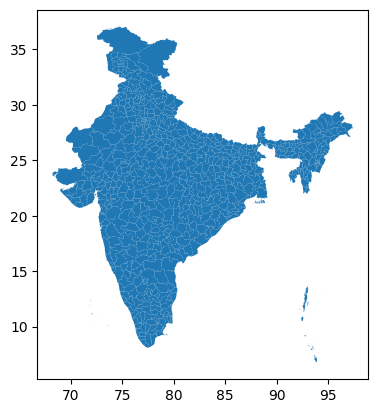

In [4]:
Ind.plot()

In [5]:
states = Ind.dissolve(by='statename',aggfunc='sum').reset_index()
states = states[['statename', 'distarea', 'totalpopul','totpopmale', 'totpopfema', 'geometry']]
states['statename'] = states['statename'].str.upper()

<ipython-input-5-a078edf64242>:1: FutureWarning: The default value of numeric_only in aggfunc='sum' within pandas.DataFrameGroupBy.agg used in dissolve is deprecated. In pandas 2.0, numeric_only will default to False. Either specify numeric_only as additional argument in dissolve() or select only columns which should be valid for the function.
  states = Ind.dissolve(by='statename',aggfunc='sum').reset_index()


<Axes: >

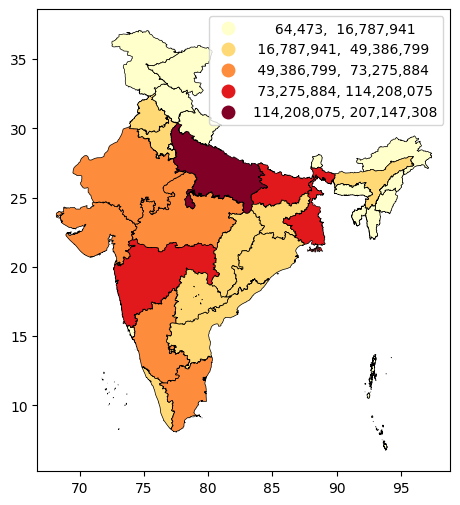

In [6]:
states.plot(figsize=(8,6),column='totalpopul',legend=True,cmap='YlOrRd',scheme='natural_breaks',k=5,
         edgecolor='black',linewidth=.5,legend_kwds= {"fmt": "{:,.0f}"})

## CRIME

In [7]:
crime = df_crime.groupby('States/UTs')['Total Cognizable IPC crimes'].sum().reset_index()
crime['States/UTs'] = crime['States/UTs'].str.upper()
crime.rename(columns= {'States/UTs':'STATE'}, inplace=True)
states.rename(columns= {'statename':'STATE'}, inplace=True)

In [8]:
# USING FUZZYWUZZY
crime["best_match"] = crime["STATE"].map(lambda x: process.extractOne(x,states["STATE"])[0] )

In [9]:
crime_pop = pd.merge(states, crime,left_on='STATE', right_on='best_match',how='outer',indicator=True)

In [13]:
crime_pop["crime_popu"] = (crime_pop['Total Cognizable IPC crimes'] /(crime_pop["totalpopul"]/1000))

<Axes: >

[]

[]

Text(0.5, 36.72222222222221, 'Max :NCT OF DELHI, Min :MEGHALAYA')

<Axes: >

[]

[]

Text(0.5, 36.72222222222221, 'Max :MADHYA PRADESH, Min :LAKSHADWEEP')

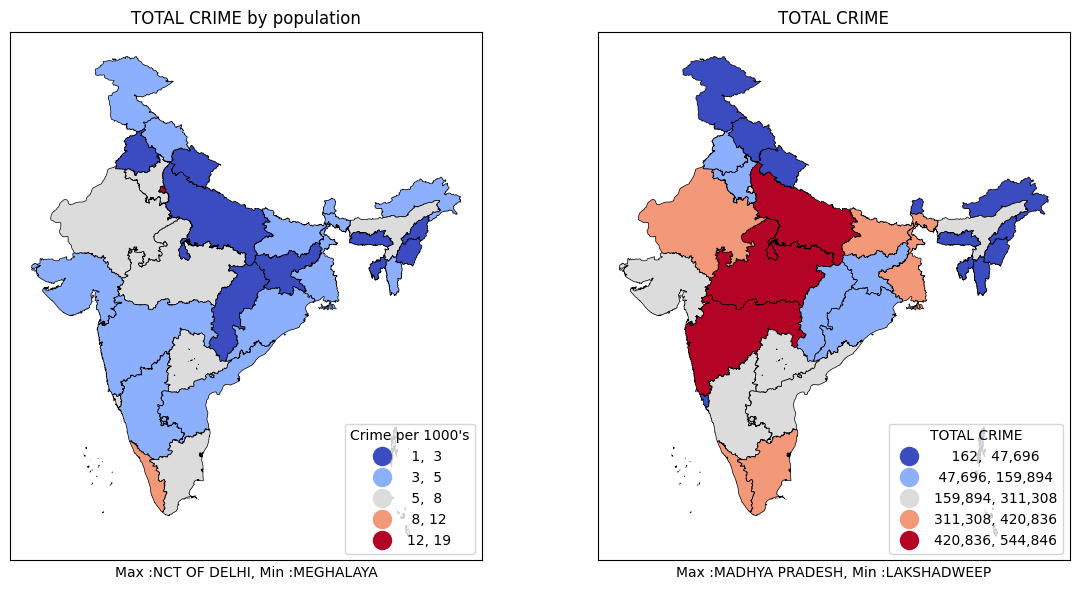

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
crime_pop.plot(ax=ax1,column='crime_popu',legend=True,cmap='coolwarm',
          scheme='natural_breaks',k=5, edgecolor='black',linewidth=0.5,
          legend_kwds= {"fmt": "{:,.0f}",'loc':'lower right','markerscale':1.4})
leg1 = ax1.get_legend()
leg1.set_title('''Crime per 1000's''')
ax1.title.set_text("TOTAL CRIME by population")
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xlabel(f"Max :{crime_pop.loc[crime_pop['crime_popu'].idxmax(), 'STATE_x']}, Min :{crime_pop.loc[crime_pop['crime_popu'].idxmin(), 'STATE_x']}")


crime_pop.plot(ax=ax2,column='Total Cognizable IPC crimes',legend=True,cmap='coolwarm',
          scheme='natural_breaks',k=5, edgecolor='black',linewidth=0.5,
          legend_kwds= {"fmt": "{:,.0f}",'loc':'lower right','markerscale':1.4})
leg1 = ax2.get_legend()
leg1.set_title('''TOTAL CRIME''')
ax2.title.set_text("TOTAL CRIME")
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_xlabel(f"Max :{crime_pop.loc[crime_pop['Total Cognizable IPC crimes'].idxmax(), 'STATE_x']}, Min :{crime_pop.loc[crime_pop['Total Cognizable IPC crimes'].idxmin(), 'STATE_x']}")

plt.tight_layout()

plt.show()

## Literacy

In [18]:
literacy = df_edu.groupby('statename')['overall_literacy'].mean().reset_index() # Mean
schools = df_edu.groupby('statename')['no_of_schools'].sum().reset_index()
education = pd.merge(literacy, schools ,on = "statename", how='outer',indicator=False)
#FuzzyWuzzy
education["best_match"] = education["statename"].map(lambda x: process.extractOne(x,states["STATE"])[0] )

In [19]:
edu_pop = pd.merge(states, education,left_on='STATE', right_on='best_match',how='outer',indicator=True)

<Axes: >

[]

[]

Text(0.5, 36.72222222222221, 'max literacy rate: KERALA , min literacy rate: BIHAR')

<Axes: >

[]

[]

Text(0.5, 36.72222222222221, 'max schools : UTTAR PRADESH , min schools : LAKSHADWEEP')

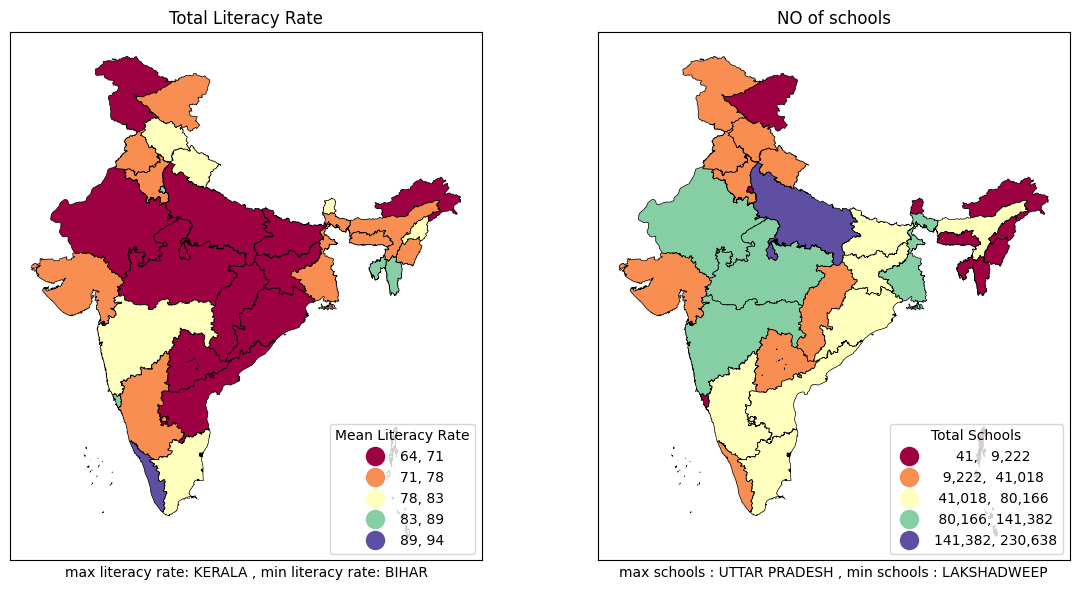

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

edu_pop.plot(ax=ax1,column='overall_literacy',legend=True,cmap='Spectral',scheme='natural_breaks',k=5, edgecolor='black',linewidth=0.5,legend_kwds= {"fmt": "{:,.0f}",'loc':'lower right','markerscale':1.4})
leg1 = ax1.get_legend()
leg1.set_title('''Mean Literacy Rate''')
ax1.title.set_text("Total Literacy Rate")
ax1.set_xticks([]) #kills xticks
ax1.set_yticks([]) #kills xticks
ax1.set_xlabel(f"max literacy rate: {edu_pop.loc[edu_pop['overall_literacy'].idxmax(), 'STATE']} , min literacy rate: {edu_pop.loc[edu_pop['overall_literacy'].idxmin(), 'STATE']}")

edu_pop.plot(ax=ax2,column='no_of_schools',legend=True,cmap='Spectral',scheme='natural_breaks',k=5, edgecolor='black',linewidth=0.5,legend_kwds= {"fmt": "{:,.0f}",'loc':'lower right','markerscale':1.4})
leg1 = ax2.get_legend()
leg1.set_title('''Total Schools''')
ax2.title.set_text("NO of schools")
ax2.set_xticks([]) #kills xticks
ax2.set_yticks([]) #kills xticks
ax2.set_xlabel(f"max schools : {edu_pop.loc[edu_pop['no_of_schools'].idxmax(), 'STATE']} , min schools : {edu_pop.loc[edu_pop['no_of_schools'].idxmin(), 'STATE']}")


plt.tight_layout()

plt.show()

# Literacy and Crime

<Axes: >

[]

[]

Text(0.5, 36.72222222222221, 'Max :KERALA, Min :BIHAR')

<Axes: >

[]

[]

Text(0.5, 36.72222222222221, 'Max :MADHYA PRADESH, Min :LAKSHADWEEP')

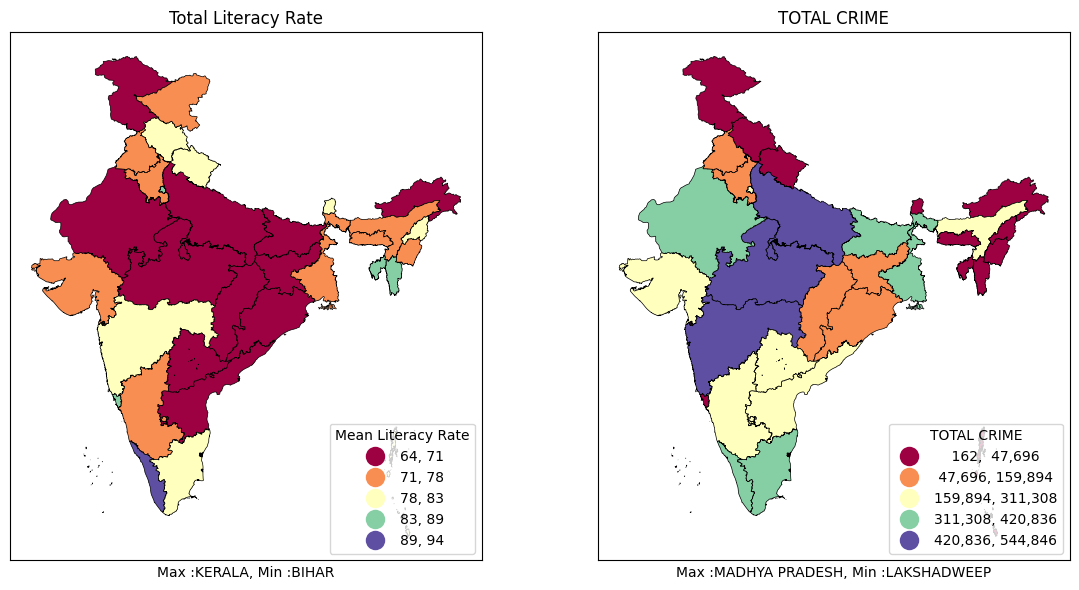

In [160]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

edu_pop.plot(ax=ax1,column='overall_literacy',legend=True,cmap='Spectral',scheme='natural_breaks',k=5, edgecolor='black',linewidth=0.5,legend_kwds= {"fmt": "{:,.0f}",'loc':'lower right','markerscale':1.4})
leg1 = ax1.get_legend()
leg1.set_title('''Mean Literacy Rate''')
ax1.title.set_text("Total Literacy Rate")
ax1.set_xticks([]) #kills xticks
ax1.set_yticks([]) #kills xticks
ax1.set_xlabel(f"Max :{edu_pop.loc[edu_pop['overall_literacy'].idxmax(), 'best_match']}, Min :{edu_pop.loc[edu_pop['overall_literacy'].idxmin(), 'best_match']}")

crime_pop.plot(ax=ax2,column='Total Cognizable IPC crimes',legend=True,cmap='Spectral',
          scheme='natural_breaks',k=5, edgecolor='black',linewidth=0.5,
          legend_kwds= {"fmt": "{:,.0f}",'loc':'lower right','markerscale':1.4})
leg1 = ax2.get_legend()
leg1.set_title('''TOTAL CRIME''')
ax2.title.set_text("TOTAL CRIME")
ax2.set_xticks([]) #kills xticks
ax2.set_yticks([]) #kills xticks
ax2.set_xlabel(f"Max :{crime_pop.loc[crime_pop['Total Cognizable IPC crimes'].idxmax(), 'STATE_x']}, Min :{crime_pop.loc[crime_pop['Total Cognizable IPC crimes'].idxmin(), 'STATE_x']}")

plt.tight_layout()

plt.show()

In [162]:
# There is an expectation of an inverse relationship between crime rates and literacy rates.
# However, this relationship does not hold true for a significant portion of India's regions.
# For instance, in states like Kerala, Tamil Nadu, and Maharashtra, both crime rates and literacy rates are on the rise.
# Conversely, in many eastern Indian states, crime rates tend to be low in areas where literacy rates are also low.
# The only exception to this trend is found in states like Rajasthan, Madhya Pradesh, Uttar Pradesh, Bihar, and West Bengal, where crime rates are elevated, while literacy rates remain comparatively lower.

In [29]:
C1c = crime_pop.copy()
C1c["geometry"] = C1c["geometry"].centroid
crime_up_literacy_down = states.query("STATE=='BIHAR'| STATE == 'UTTAR PRADESH' | STATE =='MADHYA PRADESH' | STATE =='RAJASTHAN' | STATE == 'WEST BENGAL'")

<ipython-input-29-fa318228087d>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  C1c["geometry"] = C1c["geometry"].centroid


<Axes: >

[]

[]

<Axes: >

<Axes: title={'center': 'Literacy rate(bg) |crime'}>

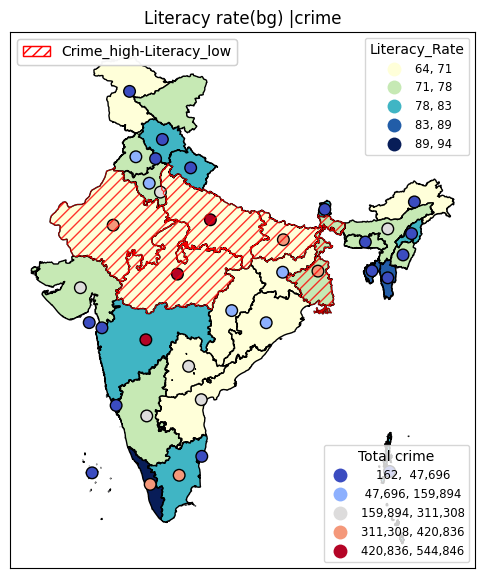

In [157]:
fig, ax = plt.subplots(1, figsize=(6,14))
edu_pop.plot(ax=ax,column='overall_literacy',legend=True,cmap='YlGnBu',scheme='natural_breaks',k=5,
         edgecolor='black',linewidth=1,legend_kwds= {"fmt": "{:,.0f}",
        'loc':'upper right','title_fontsize':'medium','fontsize':'small','markerscale':1})

l1 = ax.get_legend()
l1.set_title('''Literacy_Rate''')
ax.set_xticks([]); ax.set_yticks([])

ax.add_artist(l1)
C1c.plot(ax=ax,column='Total Cognizable IPC crimes',legend=True,cmap='coolwarm',scheme='natural_breaks',k=5,
         edgecolor='black',linewidth=1,legend_kwds= {"fmt": "{:,.0f}",
        'loc':'lower right','title_fontsize':'medium','fontsize':'small','markerscale':1},
         markersize = 70)


ax.title.set_text("Literacy rate(bg) |crime")

l2 = ax.get_legend()
l2.set_title('''Total''')

crime_up_literacy_down.plot(ax=ax,edgecolor='red',linewidth=.5, facecolor="none",alpha=.8,hatch='///')
l1 = ax.get_legend()
l1.set_title('''Total crime''')


bluePatch = mpatches.Patch(edgecolor='red', facecolor='none',
                     hatch='///', label=r'Crime_high-Literacy_low')

l2=plt.legend(handles=[bluePatch],loc='upper left')


ax.add_artist(l2)
ax.add_artist(l1)


# Unemployment

In [33]:
df_unemp["approx_2014"]  = df_unemp[['2011-12', '2017-18']].mean(axis=1)
# manually creating colfor year 2014

<ipython-input-33-6fdfae869ceb>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_unemp["approx_2014"]  = df_unemp[['2011-12', '2017-18']].mean(axis=1)


In [34]:
df_unemp['State/Union Territory'] = df_unemp['State/Union Territory'].str.upper()
df_unemp.rename(columns= {'State/Union Territory':'STATE'}, inplace=True)
df_unemp.drop(df_unemp.index[-1], inplace=True)

In [35]:
df_unemp["best_match"] = df_unemp["STATE"].map(lambda x: process.extractOne(x,states["STATE"])[0])

In [36]:
unemp = df_unemp[["approx_2014","best_match"]]

In [37]:
unemp_pop = pd.merge(states, unemp,left_on='STATE', right_on='best_match',how='outer',indicator=True)

<Axes: >

[]

[]

Text(0.5, 36.72222222222221, 'Max :NAGALAND, Min :MEGHALAYA')

<Axes: >

[]

[]

Text(0.5, 36.72222222222221, 'Max :KERALA, Min :BIHAR')

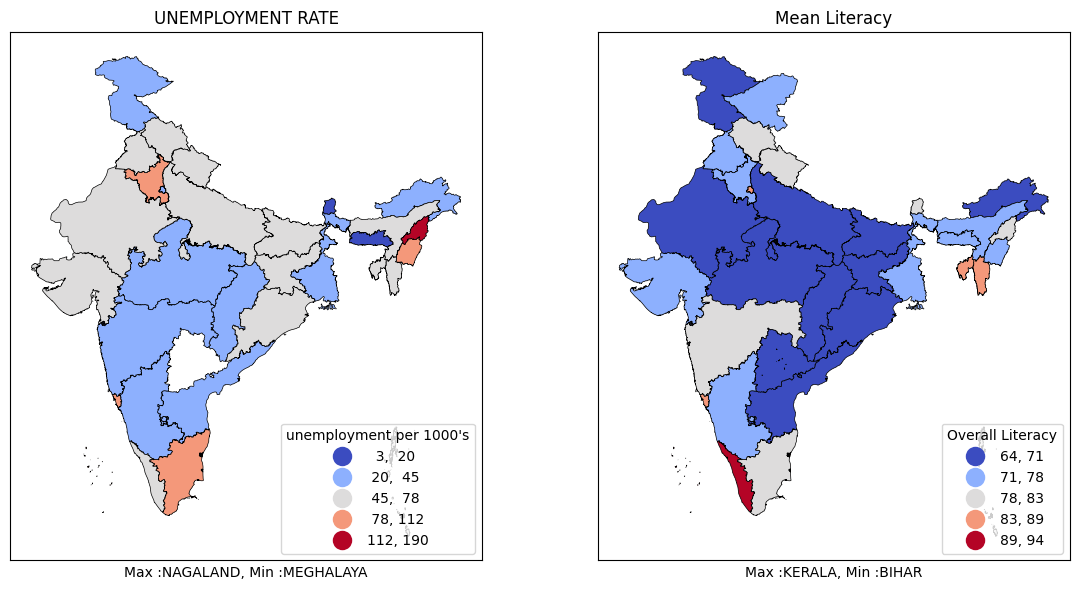

In [165]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
unemp_pop.plot(ax=ax1,column='approx_2014',legend=True,cmap='coolwarm',
          scheme='natural_breaks',k=5, edgecolor='black',linewidth=0.5,
          legend_kwds= {"fmt": "{:,.0f}",'loc':'lower right','markerscale':1.4})
leg1 = ax1.get_legend()
leg1.set_title('''unemployment per 1000's''')
ax1.title.set_text("UNEMPLOYMENT RATE")
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xlabel(f"Max :{unemp_pop.loc[unemp_pop['approx_2014'].idxmax(), 'best_match']}, Min :{unemp_pop.loc[unemp_pop['approx_2014'].idxmin(), 'best_match']}")


edu_pop.plot(ax=ax2,column='overall_literacy',legend=True,cmap='coolwarm',
          scheme='natural_breaks',k=5, edgecolor='black',linewidth=0.5,
          legend_kwds= {"fmt": "{:,.0f}",'loc':'lower right','markerscale':1.4})
leg1 = ax2.get_legend()
leg1.set_title('''Overall Literacy''')
ax2.title.set_text("Mean Literacy")
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_xlabel(f"Max :{edu_pop.loc[edu_pop['overall_literacy'].idxmax(), 'best_match']}, Min :{edu_pop.loc[edu_pop['overall_literacy'].idxmin(), 'best_match']}")


plt.tight_layout()

plt.show()

In [163]:
# we should expect HI unemployment when Literacy is Low
# Haryana, manipur and nagaland satisfies the above clause
#Goa,Tamilnadu and kerala have HI literacy but still the Unemployment there is noticable.


# LITERACY | CRIME | UNEMPLOYMENT

In [40]:
## LITERACY(BASE) | CRIME | UNEMPLOYMENT

In [43]:
U1c = unemp_pop.copy()
U1c["geometry"] = U1c["geometry"].centroid

#crime up and literacy down
crime_up_literacy_down = states.query("STATE=='BIHAR'| STATE == 'UTTAR PRADESH' | STATE =='MADHYA PRADESH' | STATE =='RAJASTHAN' | STATE == 'WEST BENGAL'")
unemp_up_literacy_down = states.query("STATE=='HARYANA'| STATE == 'MANIPUR' | STATE == 'NAGALAND'")

<ipython-input-43-fe385dc7a880>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  U1c["geometry"] = U1c["geometry"].centroid


<Axes: >

<Axes: >

<Axes: >

Text(0.5, 1.0, 'Literacy/Crime Relationship')

[]

[]

<Axes: >

<Axes: >

<Axes: >

Text(0.5, 1.0, 'Literacy/Unemployment')

[]

[]

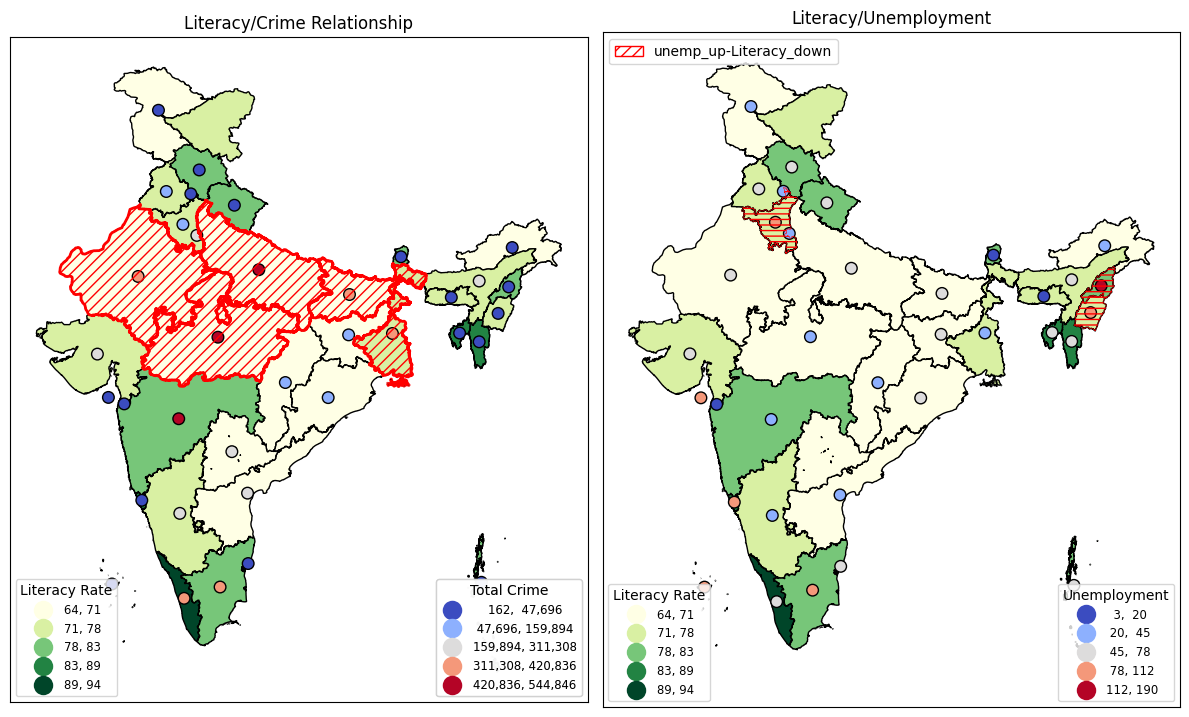

In [52]:
fig, axs = plt.subplots(1, 2, figsize=(12, 10))

# First subplot (left)
ax = axs[0]
edu_pop.plot(ax=ax, column='overall_literacy', legend=True, cmap='YlGn', scheme='natural_breaks', k=5,
          edgecolor='black', linewidth=1, legend_kwds={"fmt": "{:,.0f}",
          'loc':'lower left', 'title_fontsize':'medium', 'fontsize':'small', 'markerscale':1.4})

l1 = ax.get_legend()
l1.set_title('Literacy Rate')

C1c.plot(ax=ax, column='Total Cognizable IPC crimes', legend=True, cmap='coolwarm', scheme='natural_breaks', k=5,
           edgecolor='black', linewidth=1, legend_kwds={"fmt": "{:,.0f}",
          'loc':'lower right', 'title_fontsize':'medium', 'fontsize':'small', 'markerscale':1.4},
          markersize=70)

crime_up_literacy_down.plot(ax=ax,edgecolor='red',linewidth=2, facecolor="none",alpha=1,hatch='///')

ax.set_title("Literacy/Crime Relationship")
ax.set_xticks([]); ax.set_yticks([])

l2 = ax.get_legend()
l2.set_title('Total Crime')

ax.add_artist(l2)
ax.add_artist(l1)

bluePatch = mpatches.Patch(edgecolor='red', facecolor='none',
                     hatch='///', label=r'crime_up-Literacy_down')
l1=plt.legend(handles=[bluePatch],loc='upper left')


# Second subplot (right)
ax = axs[1]
edu_pop.plot(ax=ax, column='overall_literacy', legend=True, cmap='YlGn', scheme='natural_breaks', k=5,
          edgecolor='black', linewidth=1, legend_kwds={"fmt": "{:,.0f}",
          'loc':'lower left', 'title_fontsize':'medium', 'fontsize':'small', 'markerscale':1.4})

l1 = ax.get_legend()
l1.set_title('Literacy Rate')

U1c.plot(ax=ax, column='approx_2014', legend=True, cmap='coolwarm', scheme='natural_breaks', k=5,
           edgecolor='black', linewidth=1, legend_kwds={"fmt": "{:,.0f}",
          'loc':'lower right', 'title_fontsize':'medium', 'fontsize':'small', 'markerscale':1.4},
          markersize=70)

unemp_up_literacy_down.plot(ax=ax,edgecolor='red',linewidth=.3, facecolor="none",alpha=1,hatch='---')

ax.set_title("Literacy/Unemployment")
ax.set_xticks([]); ax.set_yticks([])

l2 = ax.get_legend()
l2.set_title('Unemployment')

ax.add_artist(l2)
ax.add_artist(l1)



bluePatch1 = mpatches.Patch(edgecolor='red', facecolor='none',
                     hatch='///', label=r'unemp_up-Literacy_down')
l2=plt.legend(handles=[bluePatch1],loc='upper left')


plt.tight_layout()

plt.show()


In [ ]:
# Exception Cases:
# Both, Crime and literacy are HI: Kerala,TamilNadu, Maharshtra
# Both, Crime and Literacy are LOW: Most of East India
# Both unemployment and Literacy are HI: Goa,tamilnadu,kerala

# SUICIDE

In [115]:
df_suicide_main = pd.read_csv("suicide.csv")


In [116]:
values_to_drop = ['Total (All India)', 'Total (States)', 'Total (UTs)','No Education','Status not known','Total','Professionals (MBA; etc.)','Graduate and above']
filtered_df = df_suicide.copy()
filtered_df.drop(filtered_df[filtered_df['CrimeHead'].str.contains('|'.join(values_to_drop))].index, inplace=True)
filtered_df.drop(filtered_df[filtered_df['CrimeHead'] == 'Professionals (MBA; etc.)'].index, inplace=True)



<ipython-input-116-25289fb52ce9>:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  filtered_df.drop(filtered_df[filtered_df['CrimeHead'].str.contains('|'.join(values_to_drop))].index, inplace=True)


In [123]:
columns_to_drop = ['Year', 'CrimeHead', 'Male', 'Female', 'Transgender']
filtered_df.drop(columns=columns_to_drop, inplace=True)

In [125]:
suicide = filtered_df.groupby('States/UTs').sum().reset_index()

In [130]:
values_to_drop = ['Total (All India)', 'Total (States)', 'Total (UTs)']
suicide = suicide[~suicide['States/UTs'].isin(values_to_drop)]

In [132]:
suicide["best_match"] = suicide["States/UTs"].map(lambda x: process.extractOne(x,states["STATE"])[0])
suicide_unemp = pd.merge(states, suicide,left_on='STATE', right_on='best_match',how='outer',indicator=True)

<ipython-input-132-741413f06fbb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  suicide["best_match"] = suicide["States/UTs"].map(lambda x: process.extractOne(x,states["STATE"])[0])


<Axes: >

[]

[]

Text(0.5, 36.72222222222221, 'Max :MAHARASHTRA, Min :LAKSHADWEEP')

<Axes: >

[]

[]

Text(0.5, 36.72222222222221, 'Max :NAGALAND, Min :MEGHALAYA')

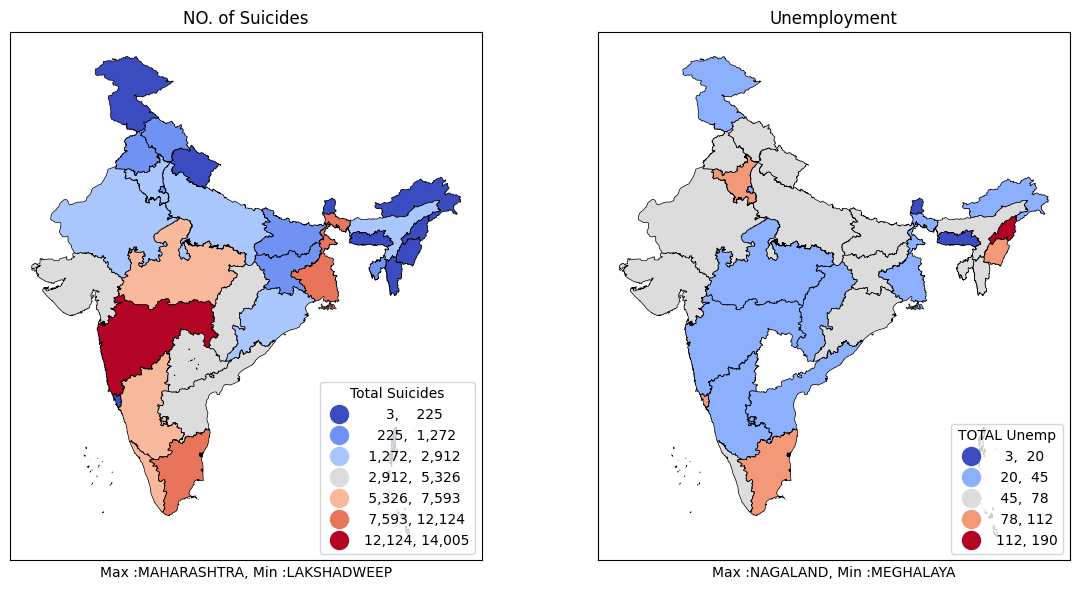

In [166]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

suicide_unemp.plot(ax=ax1,column='Total',legend=True,cmap='coolwarm',scheme='natural_breaks',k=7, edgecolor='black',linewidth=0.5,legend_kwds= {"fmt": "{:,.0f}",'loc':'lower right','markerscale':1.4})
leg1 = ax1.get_legend()
leg1.set_title('''Total Suicides''')
ax1.title.set_text("NO. of Suicides")
ax1.set_xticks([]) #kills xticks
ax1.set_yticks([]) #kills xticks
ax1.set_xlabel(f"Max :{suicide_unemp.loc[suicide_unemp['Total'].idxmax(), 'best_match']}, Min :{suicide_unemp.loc[suicide_unemp['Total'].idxmin(), 'best_match']}")

unemp_pop.plot(ax=ax2,column='approx_2014',legend=True,cmap='coolwarm',
          scheme='natural_breaks',k=5, edgecolor='black',linewidth=0.5,
          legend_kwds= {"fmt": "{:,.0f}",'loc':'lower right','markerscale':1.4})
leg1 = ax2.get_legend()
leg1.set_title('''TOTAL Unemp''')
ax2.title.set_text("Unemployment")
ax2.set_xticks([]) #kills xticks
ax2.set_yticks([]) #kills xticks
ax2.set_xlabel(f"Max :{unemp_pop.loc[unemp_pop['approx_2014'].idxmax(), 'best_match']}, Min :{unemp_pop.loc[unemp_pop['approx_2014'].idxmin(), 'best_match']}")

plt.tight_layout()

plt.show()

# UNEMPLOYMENT(BASE) | SUICIDE | CRIME

In [ ]:
S1c = suicide_unemp.copy()
S1c["geometry"] = S1c["geometry"].centroid
unemp_up_crime_up = states.query("STATE=='RAJASTHAN'| STATE == 'UTTAR PRADESH' | STATE == 'TAMIL NADU' | STATE == 'KERALA' | STATE =='BIHAR'")
unemp_up_suicide_up = states.query("STATE=='KERALA' | STATE == 'TAMIL NADU'")

<Axes: >

<Axes: >

<Axes: >

Text(0.5, 1.0, 'Unemployement/Crime Relationship')

[]

[]

<Axes: >

<Axes: >

<Axes: >

Text(0.5, 1.0, 'Unemployment/Suicide')

[]

[]

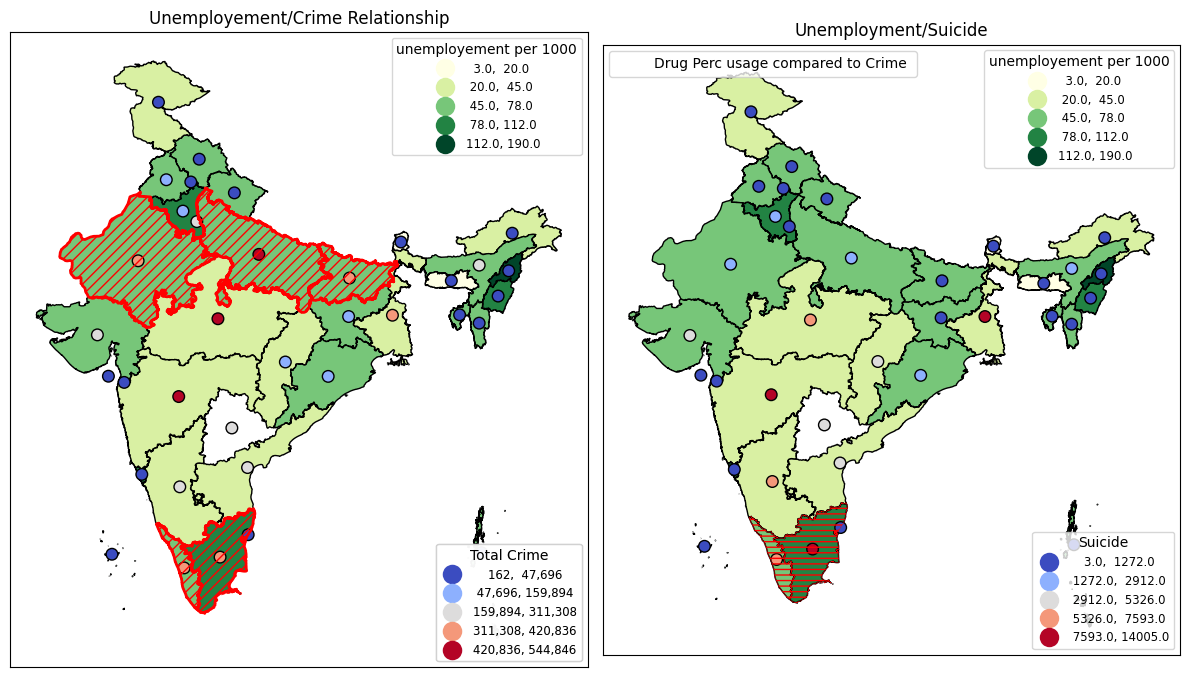

In [142]:
fig, axs = plt.subplots(1, 2, figsize=(12, 10))

# First subplot (left)
ax = axs[0]
unemp_pop.plot(ax=ax, column='approx_2014', legend=True, cmap='YlGn', scheme='natural_breaks', k=5,
          edgecolor='black', linewidth=1, legend_kwds={"fmt": "{:}",
          'loc':'upper right', 'title_fontsize':'medium', 'fontsize':'small', 'markerscale':1.4})

l1 = ax.get_legend()
l1.set_title('unemployement per 1000')

C1c.plot(ax=ax, column='Total Cognizable IPC crimes', legend=True, cmap='coolwarm', scheme='natural_breaks', k=5,
           edgecolor='black', linewidth=1, legend_kwds={"fmt": "{:,.0f}",
          'loc':'lower right', 'title_fontsize':'medium', 'fontsize':'small', 'markerscale':1.4},
          markersize=70)

unemp_up_crime_up.plot(ax=ax,edgecolor='red',linewidth=2, facecolor="none",alpha=1,hatch='///')

ax.set_title("Unemployement/Crime Relationship")
ax.set_xticks([]); ax.set_yticks([])

l2 = ax.get_legend()
l2.set_title('Total Crime')

ax.add_artist(l2)
ax.add_artist(l1)


# Second subplot (right)
ax = axs[1]
unemp_pop.plot(ax=ax, column='approx_2014', legend=True, cmap='YlGn', scheme='natural_breaks', k=5,
          edgecolor='black', linewidth=1, legend_kwds={"fmt": "{:}",
          'loc':'upper right', 'title_fontsize':'medium', 'fontsize':'small', 'markerscale':1.4})

l1 = ax.get_legend()
l1.set_title('unemployement per 1000')

S1c.plot(ax=ax, column='Total', legend=True, cmap='coolwarm', scheme='natural_breaks', k=5,
           edgecolor='black', linewidth=1, legend_kwds={"fmt": "{:}",
          'loc':'lower right', 'title_fontsize':'medium', 'fontsize':'small', 'markerscale':1.4},
          markersize=70)

unemp_up_suicide_up.plot(ax=ax,edgecolor='red',linewidth=.3, facecolor="none",alpha=1,hatch='---')

ax.set_title("Unemployment/Suicide")
ax.set_xticks([]); ax.set_yticks([])

l2 = ax.get_legend()
l2.set_title('Suicide')

ax.add_artist(l2)
ax.add_artist(l1)

import matplotlib.patches as mpatches

bluePatch = mpatches.Patch(edgecolor='white', facecolor='none',
                     hatch='---', label=r'Drug Perc usage compared to Crime ')

l2=plt.legend(handles=[bluePatch],loc='upper left')

plt.tight_layout()

plt.show()


In [ ]:
# Unemp and Suicide are HI: TAMILNADU,KERALA
# Unemp and crime is HI: UP,BIHAR,RAJASTHAN,TAMILNADU,KERALA

# Exception Cases:
# Unemp is LOW but Suicide and Crime are Hi: MP,Maharshtra,WEST BENGAL
# Unemp is Hi but Suicide is LOW: East India

# PLOTTING GRAPHS

In [145]:
# Tree Map
df = df_suicide_main
px.treemap(df, path=[px.Constant("States/UTs"), 'CrimeHead', 'Total'], values='Male',
                  color='CrimeHead', hover_data=['CrimeHead'],
                  color_continuous_scale='RdBu',
                  color_continuous_midpoint=np.average(df['Female'], weights=df['Male']))

In [147]:
px.scatter(df_suicide_main, x="CrimeHead", y="States/UTs", color="Total",
                  hover_data=['Total'],width=1000,height=600)

Text(0.5, 0.98, 'Relationship Between Literacy Rate and Unemployment (2014)')

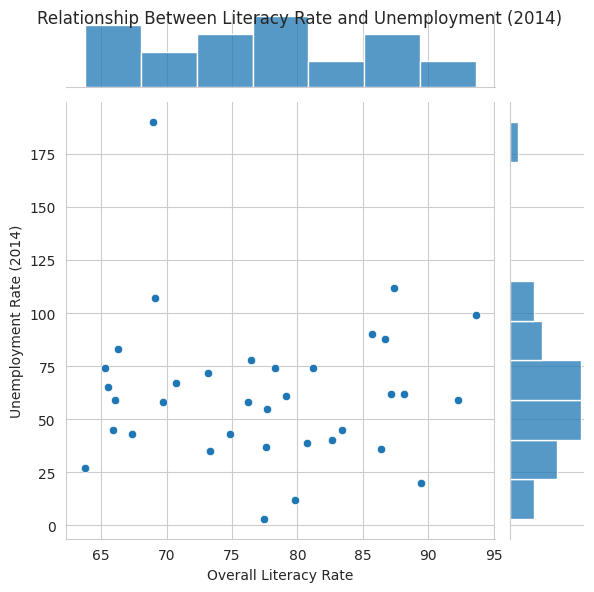

In [169]:
plot = sns.jointplot(y=unemp["approx_2014"], x=edu_pop['overall_literacy'])
plot.set_axis_labels(xlabel="Overall Literacy Rate", ylabel="Unemployment Rate (2014)")
plot.fig.suptitle("Relationship Between Literacy Rate and Unemployment (2014)")
sns.set_style("whitegrid")
plt.show()


Text(0.5, 0.98, 'Relationship Between Literacy Rate and Total IPC Crimes')

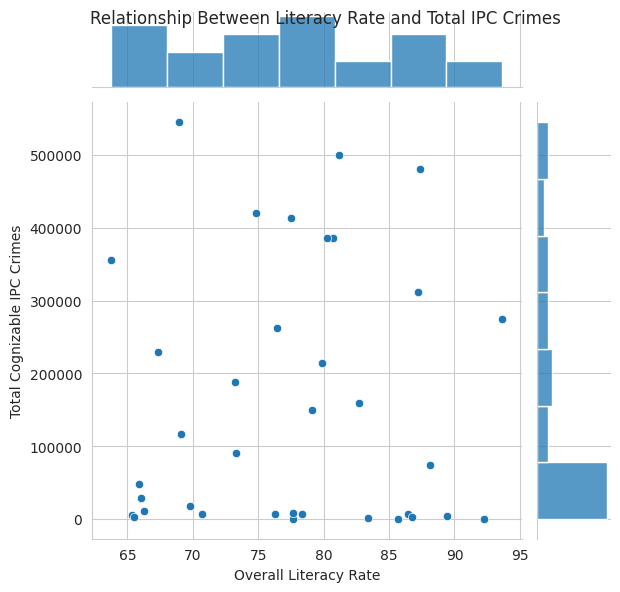

In [173]:
plot = sns.jointplot(y=crime["Total Cognizable IPC crimes"], x=edu_pop['overall_literacy'])
plot.set_axis_labels(xlabel="Overall Literacy Rate", ylabel="Total Cognizable IPC Crimes")
plot.fig.suptitle("Relationship Between Literacy Rate and Total IPC Crimes")
sns.set_style("whitegrid")
plt.show()

Text(0.5, 0.98, 'Relationship Between Unemployment Rate and Total IPC Crimes')

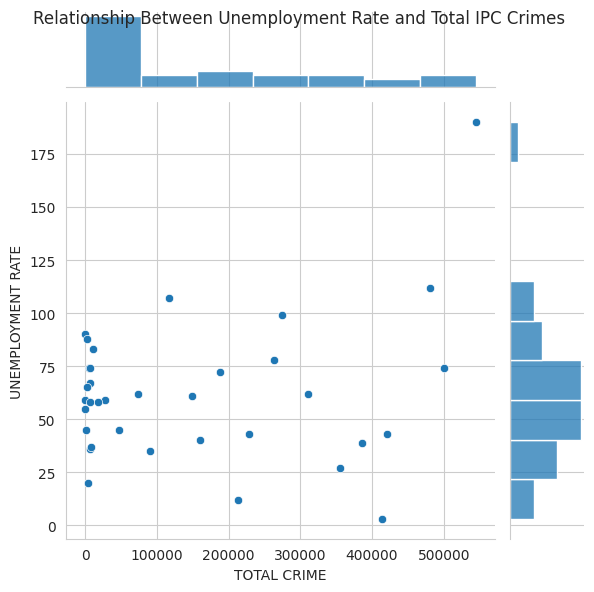

In [175]:
plot = sns.jointplot(y =unemp["approx_2014"], x =crime["Total Cognizable IPC crimes"])
plot.set_axis_labels(xlabel="TOTAL CRIME", ylabel="UNEMPLOYMENT RATE")
plot.fig.suptitle("Relationship Between Unemployment Rate and Total IPC Crimes")
sns.set_style("whitegrid")
plt.show()

Text(0.5, 0.98, 'Relationship Between Unemployment Rate and Suicides')

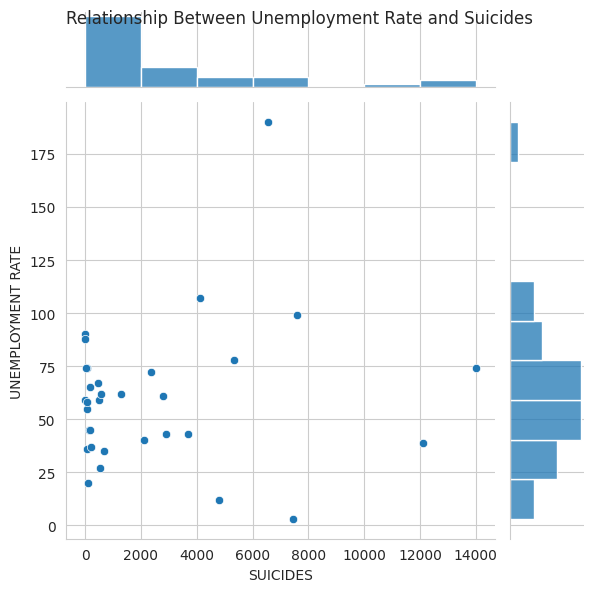

In [177]:
plot = sns.jointplot(y =unemp["approx_2014"], x =suicide['Total'])
plot.set_axis_labels(xlabel="SUICIDES", ylabel="UNEMPLOYMENT RATE")
plot.fig.suptitle("Relationship Between Unemployment Rate and Suicides")
sns.set_style("whitegrid")
plt.show()

Text(0.5, 0.98, 'Relationship Between Literacy Rate and Suicides')

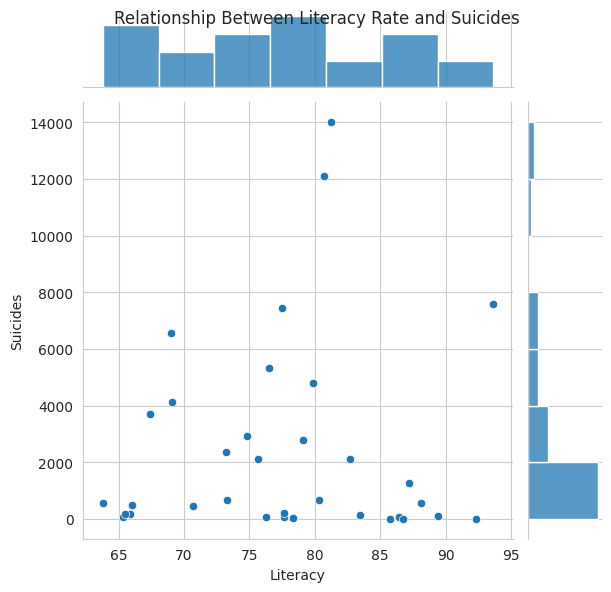

In [179]:
plot = sns.jointplot(y =suicide["Total"], x =edu_pop['overall_literacy'])
plot.set_axis_labels(xlabel="Literacy", ylabel="Suicides")
plot.fig.suptitle("Relationship Between Literacy Rate and Suicides")
sns.set_style("whitegrid")
plt.show()